In [2]:
import torch.nn as nn
import torch
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm
import numpy as np
import pickle

In [16]:
os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/Datasets/")
filename = "EuroparlNutidsr_trainset_verbs.csv"
print("Loading df...")
df = pd.read_csv(filename, encoding="UTF-8", sep=";")
pos = list(df["comment_text"].values)
labels = list(df["label"].values)

X_train, X_test, y_train, y_test = train_test_split(pos, labels, test_size=0.1, random_state=42)

unique_pos = ['NOUN','PUNCT','VERB','PRON','NUM','ADP','X','<PAD>','CCONJ','PROPN','AUX','SCONJ','INTJ','ADV','ADJ','PART','SYM','DET']
len(X_train)

Loading df...


1716972

In [4]:
class NutidsrTokenizer():
    def __init__(self) -> None:
        print("Initializing tokenizer...")
        self.tokenize_table = {x: i for i, x in enumerate(unique_pos)}
        print("Tokenizer initialized.")

    def __call__(self, pos_list, one_hot_encode=False):
        for pos_string in tqdm(pos_list):
            splitted_pos = pos_string.split()
            numbers = [self.tokenize_table[x] for x in splitted_pos]
            if one_hot_encode:
                yield [y for x in numbers for y in self._one_hot_encode(x)]
            else: 
                yield numbers
    
    def _one_hot_encode(self, number):
        return [1 if i == number else 0 for i in range(18)]

    def one_hot_decode(self, encoded):
        for i in range(len(encoded)):
            if encoded[i] == 1:
                yield i % 18

tokenizer = NutidsrTokenizer()
print("Tokenizing train...")
x_train_tokenized = list(tokenizer(X_train, one_hot_encode=True))
print("Tokenizing test...")
x_test_tokenized = list(tokenizer(X_test, one_hot_encode=True))
print("Done Tokenizing.")

Initializing tokenizer...
Tokenizer initialized.
Tokenizing train...


100%|██████████| 1716972/1716972 [01:06<00:00, 25684.98it/s]


Tokenizing test...


100%|██████████| 190775/190775 [00:06<00:00, 31255.76it/s]

Done Tokenizing.


In [5]:
class NutidsrModel(nn.Module):
    def __init__(self) -> None:
        super(NutidsrModel, self).__init__()
        number_of_unique_pos = 18
        number_of_pos_including_padding = 21
        self.l1 = nn.Linear(number_of_pos_including_padding*number_of_unique_pos, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 1024)
        self.l4 = nn.Linear(1024, 1024)
        self.l5 = nn.Linear(1024, 1024)
        self.l6 = nn.Linear(1024, 512)
        self.l7 = nn.Linear(512, 128)
        self.l8 = nn.Linear(128, 1)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)
        self.dropout5 = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.l1(x)
        x = self.activation(x)
        x = self.dropout1(x)
        x = self.l2(x)
        x = self.activation(x)
        x = self.dropout2(x)
        x = self.l3(x)
        x = self.activation(x)
        x = self.dropout3(x)
        x = self.l4(x)
        x = self.activation(x)
        x = self.dropout4(x)
        x = self.l5(x)
        x = self.activation(x)
        x = self.dropout5(x)
        x = self.l6(x)
        x = self.activation(x)
        x = self.l7(x)
        x = self.activation(x)
        x = self.l8(x)
        x = self.sigmoid(x)
        return x

In [10]:
EPOCHS, BATCH_SIZE = 1, 32

model = NutidsrModel()

## LOAD MODEL ##
# model.load_state_dict(torch.load(PATH))
##            ## 
optimizer = torch.optim.Adam(model.parameters(),lr=0.00005, weight_decay=0.0001, betas = (0.5, 0.999))
device = "cpu"
loss_fn = nn.BCELoss()
torch.device(device)
model.to(device)
n_steps = len(x_train_tokenized) // BATCH_SIZE
eval_steps = len(x_test_tokenized) // BATCH_SIZE

print("Training model...")
print("INFO: Epochs: ", EPOCHS, ". Batch size: ", BATCH_SIZE, ". Steps pr. epoch: ", n_steps, ". Eval steps: ", eval_steps)
print("Total training steps: ", n_steps*EPOCHS)
num_params = sum([len(param) for param in model.parameters()])
print("Number of parameters: ", sum([len(param) for param in model.parameters()]))

Training model...
INFO: Epochs:  1 . Batch size:  32 . Steps pr. epoch:  53655 . Eval steps:  5961
Total training steps:  53655
Number of parameters:  11522


In [11]:
def get_batch(x, y):
    indexes = random.sample(range(len(x)), BATCH_SIZE)
    x_batch = [x[i] for i in indexes]
    y_batch = [y[i] for i in indexes]
    return x_batch, y_batch

def train_model(xb, yb):
    yb = torch.tensor(yb, dtype=torch.float32)
    optimizer.zero_grad()
    xb = torch.tensor(xb, dtype=torch.float32)
    output = model.forward(xb)
    loss = loss_fn(output, yb.unsqueeze(1).float())
    loss.backward()
    optimizer.step()
    return loss

def test_model(eval_accuracies):
    accuracies = []
    for _ in tqdm(range(eval_steps)):
        xb, yb = get_batch(x_test_tokenized, y_test)
        xb = torch.tensor(xb, dtype=torch.float32)
        output = list(model.forward(xb))
        accuracy = sum([1 if to_binary(o) == y else 0 for (o,y) in zip(output, yb)])/len(output)
        accuracies.append(accuracy)
        del xb, yb, output, accuracy
    eval_accuracies.append(round(sum(accuracies)/len(accuracies)*100, 2))
    print("Eval accuracy: ", round(sum(accuracies)/len(accuracies)*100, 2), "%")
    return eval_accuracies

def to_binary(o):
    return 1 if float(o) > 0.5 else 0

def save_model(epoch):
    os.chdir("/Users/lucasvilsen/Desktop/GrammatikTAK/FineTuneModels/SimpleNutidsrNN/")
    os.makedirs(f"simpleNNmodelsPT_{num_params}", exist_ok=True)
    torch.save(model.state_dict(), f"simpleNNmodelsPT_{num_params}/model_{epoch}.pt")

In [12]:
eval_accuracy = []
losses = []

print("Accuracy before training: ")
eval_accuracy = test_model(eval_accuracy)
save_model(0)

Accuracy before training: 


100%|██████████| 5961/5961 [00:25<00:00, 231.93it/s]

Eval accuracy:  42.69 %


In [13]:
for epoch in range(EPOCHS):
    temp_losses = []
    model.train()
    for i in tqdm(range(n_steps)):
        xb, yb = get_batch(x_train_tokenized, y_train)
        xb = torch.tensor(xb)
        loss = train_model(xb, yb)
        temp_losses.append(float(loss))
        if i % 1000 == 0:
            if len(temp_losses) > 0:
                losses.append(sum(temp_losses)/len(temp_losses))
                # print(f"Loss at step {i}: {sum(temp_losses)/len(temp_losses)}")
            temp_losses = []
    
    print(f"Done with Epoch {epoch}")
    print("Evaluating...")
    model.eval()

    eval_accuracy = test_model(eval_accuracy)
    save_model(epoch+1)

  0%|          | 0/53655 [00:00<?, ?it/s]/var/folders/pl/7f1cr2657p3bnpdt3bnm_9w00000gn/T/ipykernel_8919/348398048.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(xb, dtype=torch.float32)
100%|██████████| 53655/53655 [21:21<00:00, 41.86it/s]


Done with Epoch 0
Evaluating...


100%|██████████| 5961/5961 [00:19<00:00, 299.27it/s]

Eval accuracy:  97.19 %


17666_1: 96,22%

11522: 97,16%

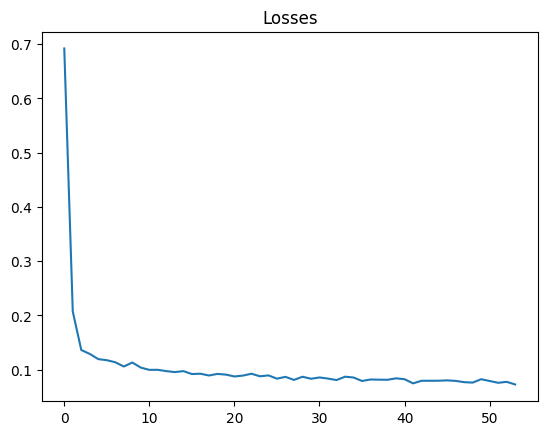

In [14]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Losses")
plt.show()

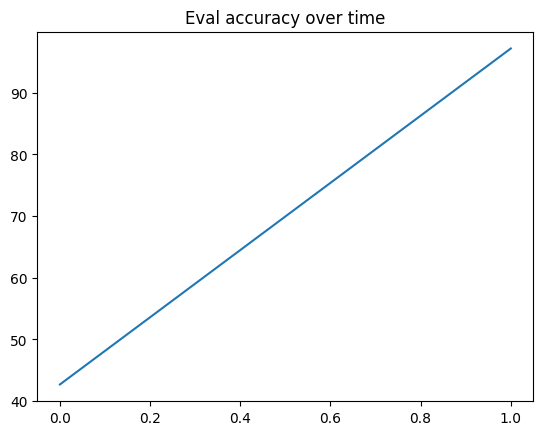

In [15]:
plt.plot(eval_accuracy)
plt.title("Eval accuracy over time")
plt.show()